# Coefficient Figure


This notebook loads, reshapes, and plots regression coefficients and CIs produced  
in `run_analysis.R`. It creates Figure 5 in the paper. 

To run this file, you will need to download all of the code and data, which is 
available at:  
https://doi.org/10.7910/DVN/WANAX3  

## Setup

In [1]:
# ------------------------------------------------------------------------------

import os
import string
import itertools
import pandas as pd
pd.set_option('display.width', 120)         # Set display width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', 50)   # Max single column width

import seaborn as sns
sns.set_style('ticks')

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

# ------------------------------------------------------------------------------

# Import custom functions
import sys
sys.path.insert(0, ".")
from functions import read_json, mm_to_inches, remove_xaxis_ticks

## Figure Settings

In [2]:
# ==============================================================================
# Plot colors and labels
label_colors = read_json('plot_colors.json')
label_orders = read_json('plot_labels.json')

# Color maps
pid7_colors = [
    "#00488C",
    "#0074E0",
    "#428bca", 
    "#cbcaca",
    "#d27979",
    "#d31d0e",
    "#8a0f00"
]
palette_alt = dict(zip(label_orders['pid7_reduced'], pid7_colors))

# ==============================================================================
# Figure sizes
# https://www.nature.com/documents/Final_guide_to_authors.pdf
# sizes: 89mm, 120mm, 183mm
FIG_WIDTH = {
    "sm": mm_to_inches(89),
    "md": mm_to_inches(120),
    "lg": mm_to_inches(180),
}
print("Figure Widths:\n", FIG_WIDTH)

# ==============================================================================
# Font settings

# Output fonts in pdf as text not shape
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# "Separate panels in multi-part figures should be labelled with 8-pt bold,
# upright (not italic) a, b, c, etc. Maximum text size for all other text: 7 pt.
# Minimum text size: 5 pt"
TINY_SIZE = 6
SMALL_SIZE = 7
LARGE_SIZE = 8

# Set default font size and family
font = {'family' : "Arial", 
        'weight' : 'regular',
        'size'   : SMALL_SIZE}
plt.rc('font', **font)   
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

# Subplot letter font
text_letters_kws = {
    "ha": "center", 
    "va": "center", 
    "rotation": 0, 
    "weight": "bold", 
    "size": LARGE_SIZE,
}

# Title text
title_kws = {
    'ha': 'center', 
    'va': 'center', 
    'size': SMALL_SIZE
}

# Legend text
legend_base_kws = {
    'prop': {'size': TINY_SIZE},
    'frameon': False, 
}

Figure Widths:
 {'sm': 3.5039370078740157, 'md': 4.724409448818897, 'lg': 7.086614173228346}


## Load Data

Load coefficients and 95% CI from regressions on 2018 and 2020 data produced by  
`run_analysis.R`

In [3]:
fp_coefficients = os.path.join("data", "coefficients.csv")
df = pd.read_csv(fp_coefficients, index_col=[0])
print(f"loaded: {fp_coefficients} - {df.shape}")
df.head()

loaded: data/coefficients.csv - (108, 16)


,var,behavior,outcome,year,model,lower_without_query,coef_without_query,upper_without_query,p_without_query,t_without_query,lower_with_query,coef_with_query,upper_with_query,p_with_query,t_with_query,N
1,Age Group: 25-44,Search Results,Unreliable URLs,2018,Negative Binomial,-0.354063,0.127665,0.609393,0.602225,0.521838,-0.284664,0.169258,0.623179,0.463403,0.734384,94
2,Age Group: 45-64,Search Results,Unreliable URLs,2018,Negative Binomial,-0.506558,-0.023504,0.459549,0.923743,-0.095813,-0.402082,0.059761,0.521604,0.799051,0.254847,111
3,Age Group: 65+,Search Results,Unreliable URLs,2018,Negative Binomial,-0.172410,0.370039,0.912488,0.180360,1.343244,-0.127057,0.385578,0.898213,0.139771,1.481357,50
4,Not very strong Republican,Search Results,Unreliable URLs,2018,Negative Binomial,-1.571999,-0.732178,0.107643,0.087219,-1.716708,-1.261994,-0.503554,0.254885,0.192204,-1.307618,10
5,Ind/Lean Democrat,Search Results,Unreliable URLs,2018,Negative Binomial,-0.562427,0.025255,0.612938,0.932628,0.084620,-0.496470,0.038794,0.574059,0.886608,0.142744,23


## Reshape Data

In [4]:

def clean_labels(df):

    # Cleaning
    df['var'] = df['var'].str.replace("Democrat", "Dem.")
    df['var'] = df['var'].str.replace("Republican", "Rep.")
    df['var'] = df['var'].str.replace("Ind/", "")
    
    # Set variable-only name column
    df['group'] = None
    mask = df['var'].str.startswith("Age")
    df.loc[mask, 'group'] = "Age Group"
    df.loc[~mask, 'group'] = "7-Point Party ID"
    
    # Extract labels
    df['label'] = None
    mask = df['group'] == 'Age Group'
    df.loc[mask, 'label'] = df.loc[mask, 'var'].str.split(': ', expand=True)[1]
    df.loc[~mask, 'label'] = df.loc[~mask, 'var']
    
    # Rename types
    df['type'] = df['behavior'].map({
        "Search Results": "Google Search Exposure", 
        "Follows from Search": "Google Search Follows",
        "Browser History": "Overall Engagement"
    })
        
    # Drop columns
    cols_drop = ["behavior", "model", "var"]
    df.drop(columns=cols_drop, inplace=True)
       
    return df

def reshape_data(df):
    cols_index = ['outcome', 'year', 'type', 'group', 'label']
    cols_values = [
        'coef_without_query', 'lower_without_query', 'upper_without_query', 
        'coef_with_query', 'upper_with_query', 'lower_with_query', 
        'p_without_query', 'p_with_query'
    ]
    tab = df[cols_index + cols_values].copy()
    
    # Melt
    melted = tab.melt(id_vars=cols_index, value_vars=cols_values)
    name_split = melted['variable'].str.split('_', n=1, expand=True)
    name_split.columns = ["value_type", "query"]
    tab = pd.concat([melted, name_split], axis=1)

    cols_order = [
        'outcome',
        'year',
        'type',
        'group',
        'label',
        'query',
        'value_type',
        'value',
    ]
    tab = tab[cols_order]
    return tab


def format_plot_data(df):
    index_cols = ['outcome', 'year', 'type', 'query', 'group', 'label']
    tab = df.pivot_table(index=index_cols, 
                         columns=['value_type'],
                         values=['value'])
    tab = tab.reset_index()
    tab.columns = ["_".join(c).rstrip('_') for c in tab.columns.to_flat_index()]
    return tab   
    
df = clean_labels(df)
df = reshape_data(df)
df = format_plot_data(df)
print(df.shape)
df.head()

(180, 10)


,outcome,year,type,query,group,label,value_coef,value_lower,value_p,value_upper
0,Partisan Slant,2018,Google Search Exposure,with_query,7-Point Party ID,Lean Dem.,0.000607,-0.050218,0.981238,0.051433
1,Partisan Slant,2018,Google Search Exposure,with_query,7-Point Party ID,Lean Rep.,0.093172,0.030706,0.003618,0.155638
2,Partisan Slant,2018,Google Search Exposure,with_query,7-Point Party ID,Not very strong Dem.,0.027301,-0.020692,0.263618,0.075295
3,Partisan Slant,2018,Google Search Exposure,with_query,7-Point Party ID,Not very strong Rep.,0.012103,-0.052382,0.711950,0.076587
4,Partisan Slant,2018,Google Search Exposure,with_query,7-Point Party ID,Strong Dem.,0.000609,-0.038620,0.975634,0.039838


## Figure: Coefficients & CIs

In [5]:
include_labels = ["Strong Dem.", "Strong Rep."]
colors = [label_colors['pid7_reduced']['Strong Democrat'],
          label_colors['pid7_reduced']['Strong Republican']]
palette = dict(zip(include_labels, colors))

def plot_partisan(subset, fig=None, ax=None, yadj=0.25, linewidth=1.5, 
                  palette=palette):
    
    subset = subset.sort_values("label", ascending=False)
    
    # Default canvas size
    if not fig and ax:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
    
    errorbar_kws = dict(
        marker='o',
        linestyle='',
        linewidth=linewidth,
        markersize=0.1,
        color='gray',
        ecolor=colors[::-1]
    )
    
    marker_full_kwargs = dict(marker='o', markersize=4, linestyle='', zorder=100)
    marker_hole_kwargs = dict(marker='.', markersize=3, linestyle='', zorder=100)
    
    # Get values
    y = pd.Series(range(subset.shape[0]))
    x = subset['value_coef']
    upper = subset['value_upper']
    lower = subset['value_lower']
    labels = subset['label']

    # Plot error bar
    ax.errorbar(x=x, y=y+yadj, xerr=((x - lower), (upper - x)), **errorbar_kws)
    
    # Plot points
    for xi, yi, label in zip(x, y, labels):
        ax.plot(xi, [yi + yadj], color=palette[label], **marker_full_kwargs)

        if yadj > 0:
            # Add white marker
            ax.plot(xi, [yi + yadj], color="white", **marker_hole_kwargs)

    ax.set(xlim=(-0.2, 0.2), 
           ylim=(-0.5,1.5), 
           yticks=[])
    ax.margins(0.1)
    fig.show()

## Plot: Full Graph

/tmp/ipykernel_8310/2223819731.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


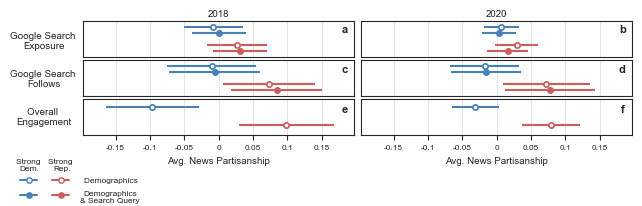

saved: outputs/figures/coefficients_partisanship.png


In [6]:
# ==============================================================================
# Plot settings

IMG_PATH = 'outputs/figures/coefficients_partisanship.png'
OVERWRITE = True

colors = ['#4682b4', '#cd5c5c']    

# Make canvas
subplot_kws = {
    'nrows': 3, 
    'ncols': 2, 
    'figsize': (FIG_WIDTH['lg'], 2), 
    'sharex': True, 
    'sharey': True, 
    'gridspec_kw': {'wspace': 0.025, 'hspace': 0.1}
}
fig, ax = plt.subplots(**subplot_kws)
ax = ax.flatten('F')

grid_kws = {
    'axis': 'x',
    'which': 'major',
    'color': '#D1D1D1', 
    'linestyle': '-', 
    'alpha': 0.8, 
    'linewidth': 0.5
}

Y_ADJUST_WITHOUT = 0.175
Y_ADJUST_WITH = -0.175
Y_ADJUST_OVERALL = 0.05

# ==============================================================================
# Plot

years = [2018, 2020]
data_types = [
    'Google Search Exposure', 
    'Google Search Follows', 
    'Overall Engagement'
]
models = ['with_query', 'without_query']

data = df.copy()
data = data.query("outcome == 'Partisan Slant' & "
                  "group == '7-Point Party ID' & "
                  "label in @include_labels")
ax_idx = 0
for year in years:
    for data_type in data_types:
        for model in models:  
            if data_type == "Overall Engagement":
                yadj = Y_ADJUST_OVERALL
                if model == "with_query":
                    continue
            else:
                yadj = Y_ADJUST_WITH if model == 'with_query' else Y_ADJUST_WITHOUT
            query = "year == @year & type == @data_type & query == @model"
            plot_partisan(data.query(query), fig, ax[ax_idx], yadj=yadj, 
                          linewidth=1.5)
        ax_idx += 1

# ==============================================================================
# Adjustments

# Set x-axis ticks on bottom only
for ax_idx in [0,1,3,4]:
    remove_xaxis_ticks(ax[ax_idx])
    
for ax_idx in [2,5]:
    ax[ax_idx].set(
        title='', 
        xlabel='Avg. News Partisanship', 
        ylabel='',
        xlim=(-0.1975,.1975),
        xticks=[-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15],
        xticklabels=['-0.15', '-0.1', '-0.05', '0', '0.05', '0.1', '0.15']
    )

# Title text
title_kws = {
    'ha': 'center', 
    'va': 'center', 
    'rotation': 0,
    'size': SMALL_SIZE
}

ax[0].set_title('2018', pad=5, **title_kws)
ax[3].set_title('2020', pad=5, **title_kws)

# Y-axis ticks - custom labels
x1 = 0.07
y1 = 0.78
yshift = 0.19

fig.text(x1, y1, "Google Search \nExposure", **title_kws)
fig.text(x1, y1-yshift, "Google Search \nFollows", **title_kws)
fig.text(x1, y1-yshift*2, "Overall \nEngagement", **title_kws)

# Add grid
for _ax in ax:
    _ax.grid(visible=True, **grid_kws)

# ==============================================================================
# Set Legend

row_labels = ["", "Demographics ", "Demographics\n& Search Query"]
col_labels = ["Strong \nDem.", "Strong \nRep."]

# Make rows
blank_kws = {"xdata": [], "ydata": [], "marker": "", "ls": ""}
legend_rows = [Line2D(label=label, **blank_kws) for label in row_labels]
legend_cols = [Line2D(label=label, **blank_kws) for label in col_labels]

# Make columns
line2d_kws = {"xdata": [], "ydata": [], "marker": ".", "markersize": 7}
legend_vals = [
    [Line2D(color=colors[0], mfc=s, **line2d_kws) for s in ['white', None]],
    [Line2D(color=colors[1], mfc=s, **line2d_kws) for s in ['white', None]],
]

# Rows first
legend_handles = [legend_cols[0]] + legend_vals[0] 
legend_handles += [legend_cols[1]] + legend_vals[1] + legend_rows 

# Legend settings
legend_kws = {
    "loc": (0.025, 0.005),
    "ncol": 3,
    "title": "",
    "markerscale": 1.1,
    "alignment": "center",
    "columnspacing": 1.7,  # Between columns spacing
    "labelspacing": 0.9,  # Between rows spacing
    "handletextpad": -3.1,
    "title_fontsize": TINY_SIZE,
    "prop": {"size": TINY_SIZE},
    "frameon": False,
    "markerfirst": False,
}

# Create legend
legend = fig.legend(handles=legend_handles, **legend_kws)

# Adjust text labels
for t in legend.get_texts():
    t.set_ha("center")
    t.set_position((-3, -2))

fig.subplots_adjust(bottom=0.31)

# Subplot labels
text_x = [0.494, 0.886]
text_y = [0.835, 0.635, 0.435]
text_xy = [reversed(tup) for tup in itertools.product(text_y, text_x)]
letters = string.ascii_lowercase[:len(text_xy)]
for l, (x, y) in zip(letters, text_xy):
    fig.text(x, y, l, **text_letters_kws)

# ==============================================================================
# Save as PNG

plt.show()
if OVERWRITE:
    fig.savefig(IMG_PATH, dpi=300, bbox_inches='tight')
    print(f"saved: {IMG_PATH}")